Esta é uma script em jupyter para fazer pequenas funções e depois passar para a script em python.

In [3]:
import os
import subprocess
from Bio import SeqIO, SeqFeature, Entrez, AlignIO, ExPASy, SwissProt
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIXML, NCBIWWW
from Bio.Align.Applications import ClustalwCommandline
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio import Phylo
from matplotlib import pyplot, rc

c:\Users\arafa\miniconda3\envs\labs\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### Análise da sequência e das features presentes no NCBI

Funtion to get gene genbank file

In [3]:
def get_seq(accession, filename, db, rettype, email="your_email@example.com", output_dir="output"):
    """
    Fetches a sequence from NCBI and saves it to a file in the specified output directory.
    
    Args:
        accession (str): NCBI Accession or ID.
        filename (str): File name to save the sequence.
        db (str): NCBI database to query (e.g., "nucleotide", "protein").
        rettype (str): Format of the returned sequence (e.g., "fasta", "gb").
        email (str): User's email for NCBI access.
        output_dir (str): Directory where the file will be saved.
    
    Returns:
        str: Full path to the saved file.
    """
    Entrez.email = email
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_path = os.path.join(output_dir, filename)  # Full path to save file

    try:
        print(f"Fetching data for accession: {accession} from {db} database...")
        handle = Entrez.efetch(db=db, id=accession, rettype=rettype, retmode="text")
        sequence_data = handle.read()
        handle.close()

        # Save the sequence to the output file
        with open(output_path, "w") as file:
            file.write(sequence_data)
        print(f"Sequence saved successfully to {output_path}.")
        return output_path

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [ ]:
get_seq("NC_000964.3", db="nucleotide",rettype="gbwithparts", filename = "genome.gb", output_dir="genome")

Fetching data for accession: NC_000964.3 from nucleotide database...
Sequence saved successfully to Genome\genome.gb.


'Genome\\genome.gb'

Funtion to extract detailed gene info from genbank complete genome file

In [1]:
def extract_gene_features(filename, gene_name):
    """
    Extracts detailed information for a specific gene or CDS from a GenBank file.
    
    Args:
        filename (str): Path to the GenBank file.
        gene_name (str): Name, locus tag, or product description of the gene or CDS.
    
    Prints:
        Detailed information about the matching gene/CDS feature.
    """
    try:
        # Read the GenBank file
        record = SeqIO.read(filename, "genbank")
        
        # Search for matching features
        matches = []
        for feature in record.features:
            qualifiers = feature.qualifiers
            if (
                "gene" in qualifiers and gene_name in qualifiers["gene"]
                or "locus_tag" in qualifiers and gene_name in qualifiers["locus_tag"]
                or "product" in qualifiers and gene_name in qualifiers["product"]
            ):
                matches.append(feature)
        
        if matches:
            print(f"Found {len(matches)} matching feature(s) for '{gene_name}':\n")
            for i, feature in enumerate(matches, 1):
                print(f"Feature {i}: {feature.type}")
                print(f"  Location: {feature.location}")
                for key, value in feature.qualifiers.items():
                    # Qualifiers are lists, join values for readability
                    print(f"  {key.capitalize()}: {', '.join(value)}")
                print("\n")
        else:
            print(f"No matching features found for '{gene_name}' in the GenBank file.")
    
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
extract_gene_features("Genome/genome.gb", "comS")

Found 2 matching feature(s) for 'comS':

Feature 1: gene
  Location: [390879:391020](+)
  Gene: comS
  Locus_tag: BSU_03500
  Old_locus_tag: BSU03500
  Db_xref: GeneID:938310


Feature 2: CDS
  Location: [390879:391020](+)
  Gene: comS
  Locus_tag: BSU_03500
  Old_locus_tag: BSU03500
  Function: 16.3: Control
  Experiment: publication(s) with functional evidences, PMID:10361283, 16554821, 8752331, 9696775, 22720735
  Note: Evidence 1a: Function from experimental evidences in the studied strain; PubMedId: 10361283, 16554821, 8752331, 9696775, 22720735; Product type r: regulator
  Codon_start: 1
  Transl_table: 11
  Product: regulator of genetic competence
  Protein_id: NP_388232.1
  Db_xref: EnsemblGenomes-Gn:BSU03500, EnsemblGenomes-Tr:CAB12144, GOA:P80355, InterPro:IPR035139, SubtiList:BG11045, UniProtKB/Swiss-Prot:P80355, GeneID:938310
  Translation: MNRSGKHLISSIILYPRPSGECISSISLDKQTQATTSPLYFCWREK




In [7]:
def extract_gene(genome_file, gene_name, output_dir="extracted_seqs"):
    """
    Extracts a specific gene by name from a GenBank genome file and saves its DNA sequence and translation.
    
    Args:
        genome_file (str): Path to the GenBank file containing the genome.
        gene_name (str): Name of the gene to extract.
        output_dir (str): Directory to save the output files.
        dna_filename (str): Name of the DNA output FASTA file.
        protein_filename (str): Name of the protein output FASTA file.
    
    Returns:
        None
    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Define full paths for the output files
        dna_output_path = os.path.join(output_dir, gene_name + "_dna.fasta")
        protein_output_path = os.path.join(output_dir, gene_name + "_protein.fasta")
        
        # Parse the GenBank file
        with open(genome_file, "r") as gb_file:
            genome_record = SeqIO.read(gb_file, "genbank")
        
        # Search for the gene in the genome annotations
        for feature in genome_record.features:
            if feature.type == "CDS" and "gene" in feature.qualifiers:
                if gene_name in feature.qualifiers["gene"]:
                    # Extract the gene sequence
                    gene_seq = feature.extract(genome_record.seq)
                    
                    # Extract the protein translation, if available
                    protein_translation = feature.qualifiers.get("translation", [None])[0]
                    
                    # Write the DNA sequence to the DNA FASTA file
                    with open(dna_output_path, "w") as dna_file:
                        dna_file.write(f">{gene_name} [NC_000964.3] DNA sequence\n{gene_seq}\n")
                    print(f"{gene_name} DNA sequence saved to {dna_output_path}.")
                    
                    # Write the protein translation to the protein FASTA file
                    if protein_translation:
                        with open(protein_output_path, "w") as protein_file:
                            protein_file.write(f">{gene_name} [NC_000964.3] Protein translation\n{protein_translation}\n")
                        print(f"{gene_name} protein translation saved to {protein_output_path}.")
                    else:
                        print(f"No protein translation available for {gene_name}.")
                    
                    return
        
        print(f"Gene {gene_name} not found in the genome.")
    
    except Exception as e:
        print(f"An error occurred: {e}")


In [8]:
extract_gene(genome_file="Genome/genome.gb", gene_name="comS")

comS DNA sequence saved to extracted_seqs\comS_dna.fasta.
comS protein translation saved to extracted_seqs\comS_protein.fasta.


### Análise de homologias por BLAST

Função para fazer um NCBI blast apartir de um file (pode-se escolher o tipo de blast, database e outros parâmetros)

In [9]:
def blast(file_name, file_format = "fasta", program = "blastn", database = "nt", e_value = 0.05, hitlist_size = 100):
    """
    Performs a BLAST search for a sequence contained in a file.
    
    Parameters:
        file_name (str): Name of the file containing the sequence.
        file_format (str): Format of the file (default: 'fasta').
        program (str): BLAST program to use (default: 'blastn').
        database (str): Database to search (default: 'nt').
        e_value (float): E-value threshold for the search (default: 0.05).
        hitlist_size (int): Number of hits to return (default: 100).
    
    Returns:
        A handle with the BLAST results, or None in case of an error.
    """

    try:
        # Open the sequence file and read it using Biopython
        record = SeqIO.read(open(file_name), format=file_format)

        print("BLASTing...")
        # Perform the BLAST search using NCBIWWW.qblast
        result_handle = NCBIWWW.qblast(program, database, record.format("fasta"), expect=e_value, hitlist_size=hitlist_size)

        # Print success message and return the BLAST results handle
        print("BLAST completed successfully.")
        return result_handle

    except Exception as e:
        # Catch any exceptions and print an error message
        print(f"Error running BLAST: {e}")
        return None

Função que utiliza função blast, mas guardar o output num file.

In [10]:
def get_blast(file_name, output_name="blast_result", output_dir="blast_output",
            file_format="fasta", program="blastn", database="nt",
            e_value=0.05, hitlist_size=100):
    """
    Performs a BLAST search using the `blast` function and saves the results to a file.
    
    Parameters:
        file_name (str): Name of the file containing the sequence.
        output_name (str): Name of the file to save the results.
        Other parameters are the same as those in the `blast` function.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, output_name)  # Full path to the output file

    result_handle = blast(file_name, file_format, program, database, e_value, hitlist_size)

    if result_handle is not None:
        try:
            # Save the results to an XML file
            with open(f"{output_path}.xml", "w") as save_file:
                save_file.write(result_handle.read())
                print(f"Results saved to {output_name}.xml.")

        except Exception as e:
            print(f"Error saving the results: {e}")

        finally:
            result_handle.close()

    

Teste da função *get_blast* 

In [11]:
get_blast("extracted_seqs/comS_dna.fasta", output_name ="comS_dna", hitlist_size=10000)

BLASTing...
BLAST completed successfully.
Results saved to comS_dna.xml.


In [12]:
get_blast("extracted_seqs/comS_protein.fasta", output_name ="comS_protein",program = "blastp", database = "nr", hitlist_size=10000)

BLASTing...
BLAST completed successfully.
Results saved to comS_protein.xml.


Função de extract de sequências

In [148]:
def get_homologous(file_name, query_fasta, exclude=None, e_value_thresh=0.05, identity_thresh=90, n_seq=20, coverage_thresh=0.7):
    """
    Extracts sequences from BLAST results for alignment, using a query FASTA file.
    
    Args:
        file_name (str): Path to the BLAST XML result file.
        query_fasta (str): Path to the query sequence FASTA file.
        exclude (list): List of species or keywords to exclude.
        e_value_thresh (float): Threshold for E-value significance.
        identity_thresh (float): Minimum percentage identity for significant hits.
        n_seq (int): Maximum number of sequences to extract.
        coverage_thresh (float): Minimum fraction of query sequence covered by the alignment (0 to 1).
    
    Returns:
        dict: Dictionary with sequence titles as keys and sequences as values, including the query sequence.
    """
    from Bio.Blast import NCBIXML
    from Bio import SeqIO

    # Read the query sequence from the FASTA file
    with open(query_fasta, "r") as fasta_handle:
        query_record = SeqIO.read(fasta_handle, "fasta")
        query_sequence = str(query_record.seq)
    
    if not query_sequence:
        raise ValueError("Query sequence could not be read from the FASTA file.")
    
    # Initialize the dictionary with the query sequence
    sequences = {"Query": query_sequence}
    significant_hits = []
    added_species = set()  # To track species that are already added

    print(f"Starting extraction with criteria: E-value < {e_value_thresh}, Identity > {identity_thresh}%, Coverage > {coverage_thresh}")
    
    # Parse the BLAST XML file
    with open(file_name) as result_handle:
        blast_record = NCBIXML.read(result_handle)

    query_length = len(query_sequence)  # Length of the query sequence
    total_alignments = len(blast_record.alignments)
    print(f"Total alignments found: {total_alignments}")

    for alignment_idx, alignment in enumerate(blast_record.alignments, 1):
        # Check exclusion criteria
        if exclude and any(term.lower() in alignment.title.lower() for term in exclude):
            continue  # Skip this alignment if it matches exclusion criteria
        
        for hsp in alignment.hsps:
            # Check E-value, identity, and coverage thresholds
            if hsp.expect < e_value_thresh and (hsp.identities / hsp.align_length) * 100 > identity_thresh:
                # Calculate coverage based on query_start and query_end
                coverage = (hsp.query_end - hsp.query_start + 1) / query_length  # Coverage as fraction of query length
                
                if coverage >= coverage_thresh:  # Check if the coverage meets the threshold
                    hit_info = {
                        "title": alignment.title,
                        "length": alignment.length,
                        "e_value": hsp.expect,
                        "identity": (hsp.identities / hsp.align_length) * 100,
                        "alignment_length": hsp.align_length,
                        "coverage": coverage
                    }
                    significant_hits.append(hit_info)
                    
                    # Extract species name from the title
                    title_parts = alignment.title.split("|")[-1]  # Use the last part of the title
                    species_name = title_parts.split("[")[-1].split("]")[0]  # Extract text within brackets
                    formatted_species_name = "_".join(species_name.split()[:2])  # Format species name
                    
                    # Add the second-to-last part of the title to the header (e.g., the accession code)
                    sequence_header = f"{formatted_species_name}|{alignment.title.split('|')[-2]}"  # Adding accession or ID code
                    
                    # Add the sequence only if the species has not been added yet
                    if formatted_species_name not in added_species:
                        sequences[sequence_header] = hsp.sbjct
                        added_species.add(formatted_species_name)  # Mark the species as added
                        
                        print(f"Added: {sequence_header} | Identity: {hit_info['identity']:.2f}% |
                               E-value: {hit_info['e_value']:.2e} | Coverage: {hit_info['coverage']:.2f}")
                        
                        if len(sequences) >= n_seq:  # Stop if desired number of sequences is reached
                            print("\nExtraction complete: Maximum sequence count reached.")
                            print(f"Total sequences extracted: {len(sequences)}")
                            print(f"Significant hits analyzed: {len(significant_hits)}")
                            return sequences

    print("\nExtraction complete.")
    print(f"Total sequences extracted: {len(sequences)}")
    print(f"Significant hits analyzed: {len(significant_hits)}")
    return sequences



In [149]:
sequences_cds=get_homologous("blast_output/comS_dna.xml", query_fasta="extracted_seqs/comS_dna.fasta",
                                        exclude=["subtilis"], e_value_thresh=0.05, identity_thresh=90, coverage_thresh=0.7)

Starting extraction with criteria: E-value < 0.05, Identity > 90%, Coverage > 0.7
Total alignments found: 1312
Added: Bacillus_sp.|CP024921.1 | Identity: 100.00% | E-value: 9.90e-64 | Coverage: 1.00
Added: Bacillus_rugosus|CP096590.1 | Identity: 99.29% | E-value: 4.21e-62 | Coverage: 1.00
Added: Bacillus_spizizenii|CP145137.1 | Identity: 98.58% | E-value: 5.13e-61 | Coverage: 1.00
Added: Bacillus_stercoris|CP124601.1 | Identity: 98.58% | E-value: 5.13e-61 | Coverage: 1.00
Added: Bacillus_tequilensis|CP048852.1 | Identity: 98.58% | E-value: 5.13e-61 | Coverage: 1.00
Added: Bacillus_inaquosorum|CP096592.1 | Identity: 97.87% | E-value: 2.18e-59 | Coverage: 1.00
Added: Bacillus_vallismortis|CP026362.1 | Identity: 97.87% | E-value: 2.18e-59 | Coverage: 1.00
Added: Bacillus_halotolerans|CP026032.1 | Identity: 97.87% | E-value: 2.18e-59 | Coverage: 1.00
Added: Bacillus_intestinalis|CP011051.1 | Identity: 97.87% | E-value: 2.18e-59 | Coverage: 1.00
Added: Bacillus_cabrialesii|CP096889.1 | Iden

In [150]:
sequences_prot=get_homologous("blast_output/comS_protein.xml", query_fasta="extracted_seqs/comS_protein.fasta",
                                        exclude=["subtilis"], e_value_thresh=0.05, identity_thresh=90, coverage_thresh=0.7)

Starting extraction with criteria: E-value < 0.05, Identity > 90%, Coverage > 0.7
Total alignments found: 96
Added: Bacillus_sp.|WP_231516564.1 | Identity: 97.83% | E-value: 8.88e-25 | Coverage: 1.00
Added: Bacillus_spizizenii|MCR4391170.1 | Identity: 97.83% | E-value: 1.47e-24 | Coverage: 1.00
Added: Bacillus_inaquosorum|MCY7941655.1 | Identity: 97.83% | E-value: 2.79e-24 | Coverage: 1.00
Added: Bacillus_vallismortis|WP_240467619.1 | Identity: 95.65% | E-value: 6.71e-24 | Coverage: 1.00
Added: Bacillus_stercoris|MEN9077508.1 | Identity: 97.83% | E-value: 9.43e-24 | Coverage: 1.00
Added: Bacillus_tequilensis|WP_254610356.1 | Identity: 95.65% | E-value: 2.13e-23 | Coverage: 1.00
Added: Bacillus_mojavensis|MCY9093305.1 | Identity: 93.48% | E-value: 1.54e-22 | Coverage: 1.00
Added: Bacillus_halotolerans|MCP9301357.1 | Identity: 91.30% | E-value: 4.37e-22 | Coverage: 1.00

Extraction complete.
Total sequences extracted: 9
Significant hits analyzed: 23


In [151]:
def save_to_fasta(sequences, output_file="sequences.fasta", output_dir="homologs"):
    """
    Saves sequences to a FASTA file, with species names as headers.
    
    Args:
        sequences (dict): Dictionary of sequences with species names as keys.
        output_file (str): Name of the FASTA file.
        output_dir (str): Directory to save the FASTA file.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, output_file)  # Full path to the output file

    # Create SeqRecord objects with species names as IDs
    records = [SeqRecord(Seq(seq), id=species, description="") for species, seq in sequences.items()]
    SeqIO.write(records, output_path, "fasta")
    print(f"Sequences saved to {output_path}.")

In [152]:
save_to_fasta(sequences_cds, "comS_dna_homologs.fasta")

Sequences saved to homologs\comS_dna_homologs.fasta.


In [153]:
save_to_fasta(sequences_prot, "comS_prot_homologs.fasta")

Sequences saved to homologs\comS_prot_homologs.fasta.


### Alinhamento múltiplo e filogenia

In [22]:
def run_clustalO(input_file, output_file="aligned_sequences.aln", output_dir="clustal_output"):
    """
    Runs Clustal Omega for multiple sequence alignment.
    
    Args:
        input_file (str): Path to the input FASTA file.
        output_file (str): Name of the output alignment file.
        output_dir (str): Directory to save the alignment result.
    
    Returns:
        str: Full path to the output alignment file.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, output_file)  # Full path to the output file

    clustalo_exe = "clustal-omega-1.2.2-win64\\clustalo"  # Path to Clustal Omega executable

    # Command to run Clustal Omega
    command = [
        clustalo_exe,
        "--infile", input_file,
        "--outfile", output_path,
        "--outfmt", "clu",  # Output format: Clustal
        "--force"  # Overwrite existing files if necessary
    ]

    try:
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        print("Clustal Omega alignment completed successfully.")
        print(result.stdout)
        return output_path
    except subprocess.CalledProcessError as e:
        print("Error during Clustal Omega execution:")
        print(e.stderr)
        raise



In [29]:
aligned_file = run_clustalO(input_file="homologs/comS_dna_homologs.fasta", output_file="comS_dna.aln", output_dir="clustal_output")

Clustal Omega alignment completed successfully.



In [24]:
aligned_file = run_clustalO(input_file="homologs/comS_prot_homologs.fasta", output_file="comS_protein.aln", output_dir="clustal_output")

Clustal Omega alignment completed successfully.



Função para costrução de árvores apartir do output do clustalOmega

In [49]:
def build_trees(file_name, file_type, gene="", matrix="blosum62", output_dir="tree_output"):
    """
    Builds phylogenetic trees (UPGMA and NJ) from a sequence alignment file.
    
    Args:
        file_name (str): Path to the input alignment file.
        file_type (str): Format of the input alignment file (e.g., "clustal", "fasta").
        matrix (str): Scoring matrix for distance calculation (default: "blosum62").
        output_dir (str): Directory to save intermediate files and outputs (default: "tree_output").
    
    Returns:
        None: Displays the trees as ASCII diagrams in the console.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    output_upgma = os.path.join(output_dir, f'{gene}_upgma.nwk')
    output_nj = os.path.join(output_dir, f'{gene}_nj.nwk')

    try:
        # Read the alignment file
        alignment = AlignIO.read(file_name, file_type)
        
        # Calculate pairwise distances
        calculator = DistanceCalculator(matrix)
        dm = calculator.get_distance(alignment)
        
        # Construct trees using UPGMA
        constructor = DistanceTreeConstructor()
        upgma_tree = constructor.upgma(dm)

        # Escreve a árvore UPGMA em um arquivo no formato Newick
        Phylo.write(upgma_tree, output_upgma, 'newick')


    except Exception as e:
        print(f"An error occurred: {e}")

In [50]:
build_trees(
    gene="comS_dna",
    file_name="clustal_output/comS_dna.aln",
    file_type="clustal",
    matrix="blosum62",
    output_dir="tree_output"
)

In [51]:
build_trees(
    gene="comS_prot",
    file_name="clustal_output/comS_protein.aln",
    file_type="clustal",
    matrix="blosum62",
    output_dir="tree_output"
)

In [127]:
def highlight_homo_clade_and_remove_inner(upgma_file):
    """
    Lê as árvores filogenéticas UPGMA e NJ, remove os rótulos 'Inner' e destaca o clado com o gênero 'Homo'.
    
    Args:
        upgma_file (str): Caminho para o arquivo da árvore UPGMA (formato Newick).
        nj_file (str): Caminho para o arquivo da árvore NJ (formato Newick).
    """
    # Leia as árvores
    upgmatree = Phylo.read(upgma_file, 'newick')

    # Remove os rótulos 'Inner' dos clados da árvore UPGMA
    for clade in upgmatree.find_clades():
        if 'Inner' in clade.name:
            clade.name = ""

    # Encontra e destaca o clado com o gênero "Homo" na árvore UPGMA
    for clade in upgmatree.find_clades():
        if 'Query' in clade.name:
            clade.color = 'orange'
            clade.name = '*** ' + clade.name + ' ***'  # Marca o clado

    # Ajusta o tamanho da figura para aumentar a largura usando plt.subplots
    fig, ax = pyplot.subplots(figsize=(22, 10), dpi=100)  # Aumente ou diminua o tamanho conforme necessário

    # Desenha as árvores, passando o eixo 'ax' para as árvores
    rc('font', size=12)
    Phylo.draw(upgmatree, do_show=False, axes=ax)
    pyplot.title("UPGMA Tree")

    # Exibe a árvore UPGMA
    pyplot.show()

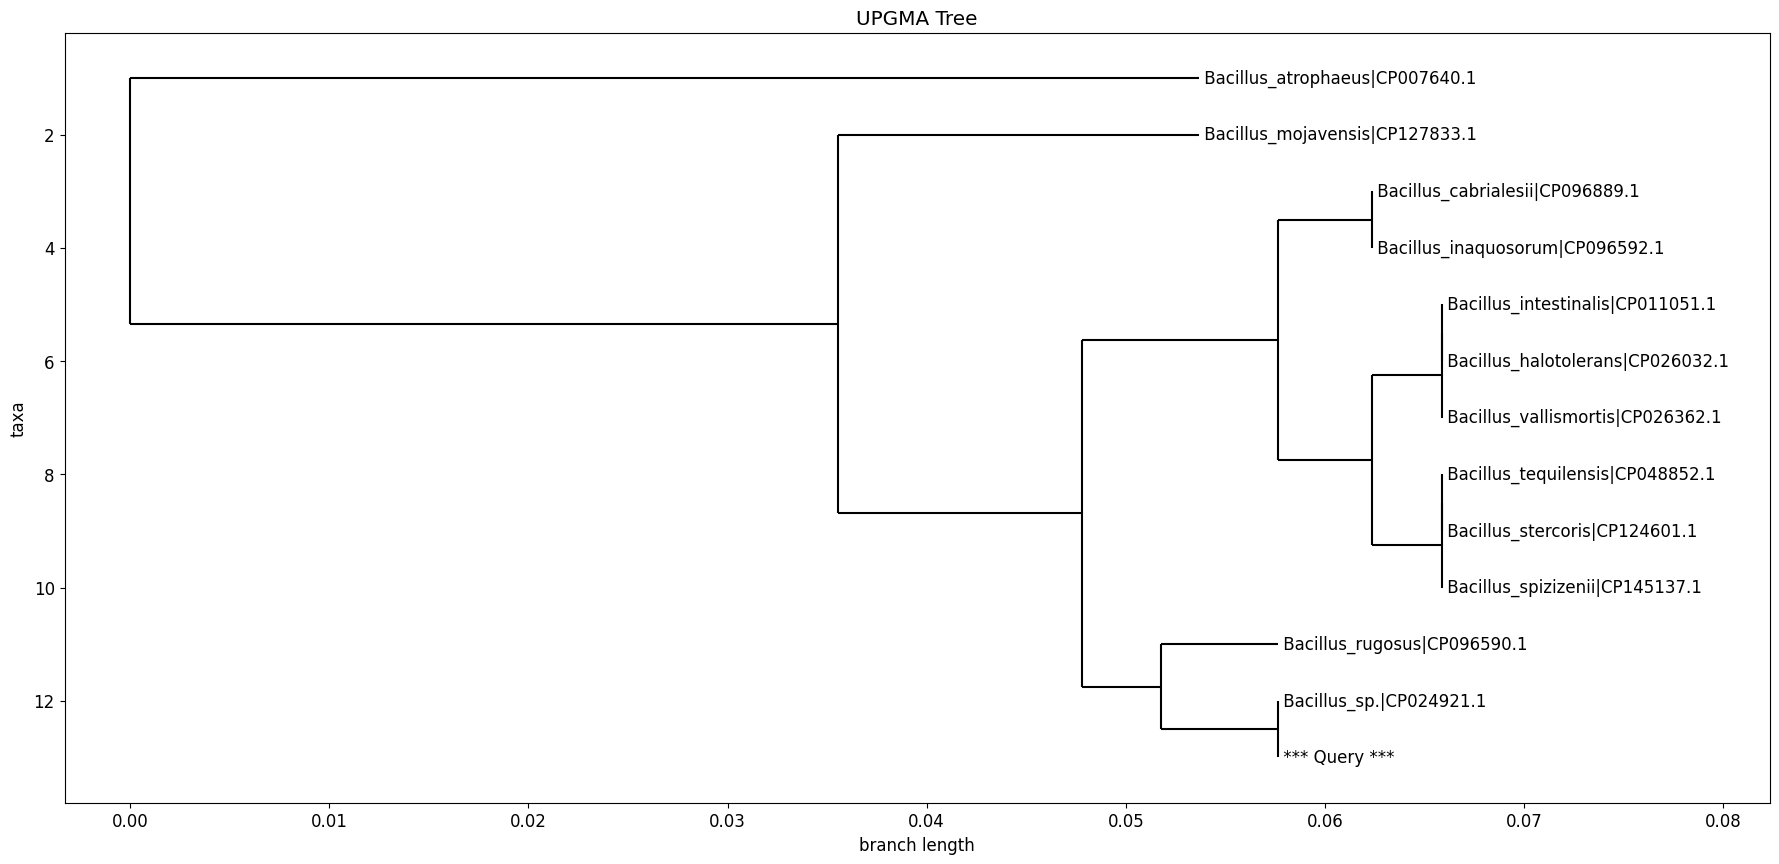

In [128]:
highlight_homo_clade_and_remove_inner('tree_output/comS_dna_upgma.nwk')

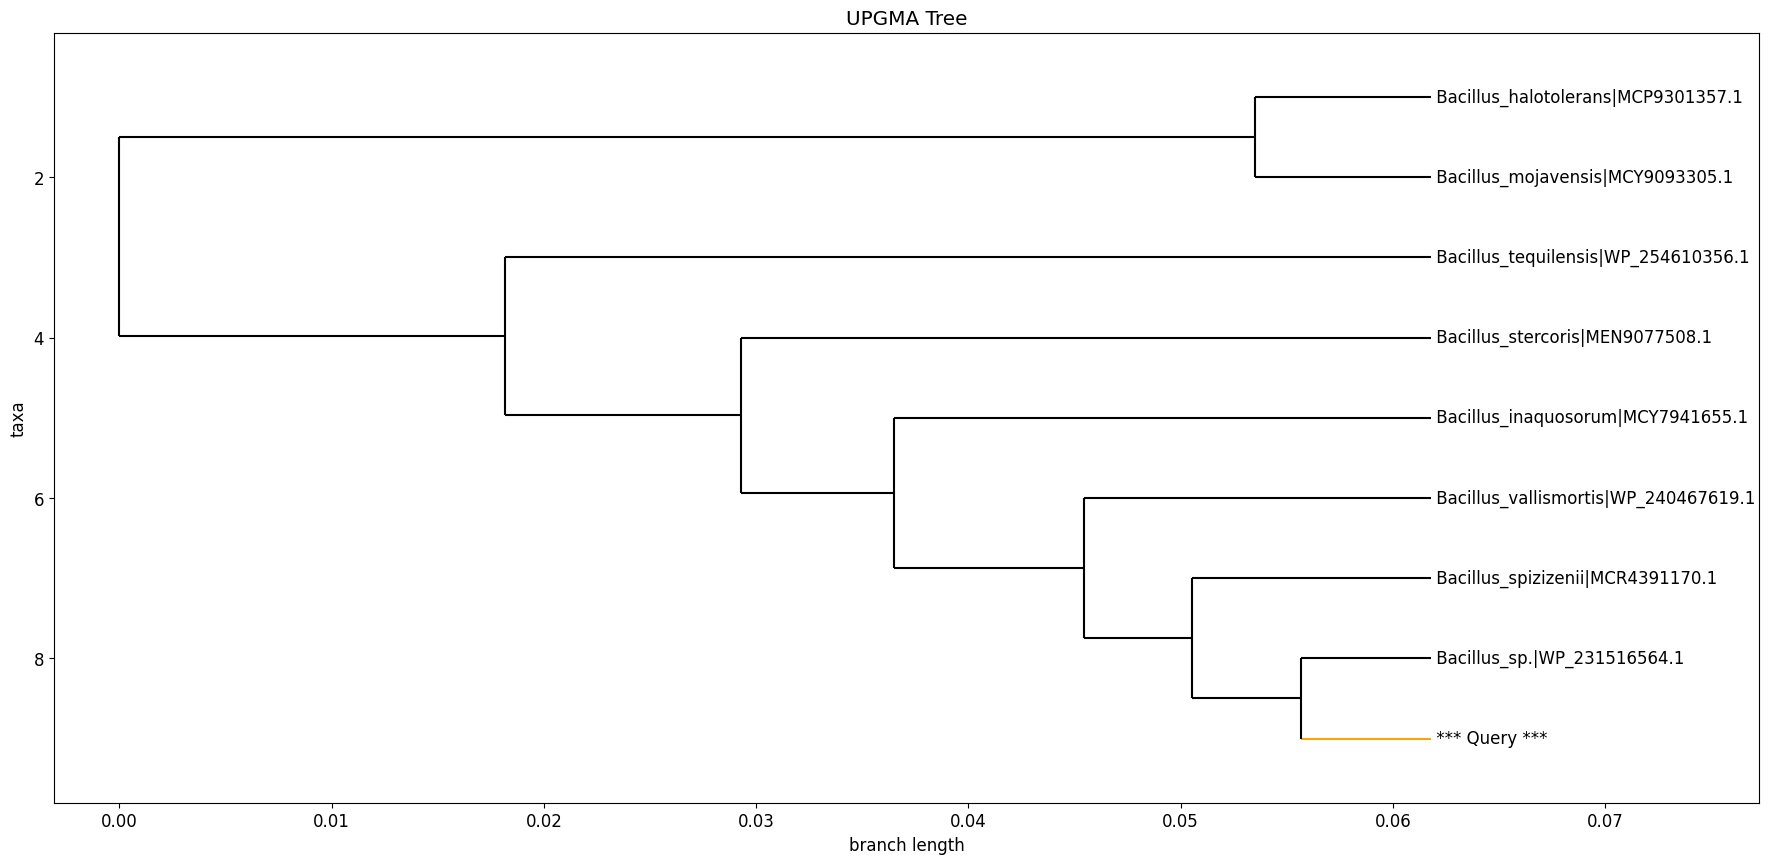

In [129]:
highlight_homo_clade_and_remove_inner('tree_output/comS_prot_upgma.nwk')